# ## 1. Setup and Data Loading
#
# Import necessary libraries and load the dataset. We'll filter the columns
# to keep only the relevant ones identified.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from pandas.tseries.offsets import Day
import warnings

# Optional: Configure settings for better display
pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore future warnings from seaborn/pandas

In [3]:

df = pd.read_csv(r'G:\Users\Clamfighter\Documents\GitHub\Football-Analytics\Data\football_data.csv', low_memory=False)



columns_to_keep = [
    "Div", "Date", "Time", "HomeTeam", "AwayTeam",
    "FTHG", "HG", "FTAG", "AG", "FTR", "Res", # Full Time Goals and Result
    "HTHG", "HTAG", "HTR",                 # Half Time Goals and Result
    "Attendance", "Referee",               # Match Info
    "HS", "AS", "HST", "AST", "HHW", "AHW", # Shots and Woodwork
    "HC", "AC",                            # Corners
    "HF", "AF", "HFKC", "AFKC",             # Fouls and Free Kicks Conceded
    "HO", "AO",                            # Offsides
    "HY", "AY", "HR", "AR",                 # Cards
    "HBP", "ABP"                           # Booking Points
]

# Filter columns that actually exist in the loaded DataFrame
columns_in_df = [col for col in columns_to_keep if col in df.columns]
df_filtered = df[columns_in_df].copy() # Use a copy to avoid SettingWithCopyWarning

# --- Data Cleaning: Handle potential alias columns ---
# Use FTHG if available, otherwise HG. Create FTHG if only HG exists.
if 'FTHG' not in df_filtered.columns and 'HG' in df_filtered.columns:
    df_filtered['FTHG'] = df_filtered['HG']
if 'FTAG' not in df_filtered.columns and 'AG' in df_filtered.columns:
    df_filtered['FTAG'] = df_filtered['AG']
if 'FTR' not in df_filtered.columns and 'Res' in df_filtered.columns:
    df_filtered['FTR'] = df_filtered['Res']

# Ensure essential columns exist after aliasing
essential_cols = ["Div", "Date", "Time", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]
missing_essentials = [col for col in essential_cols if col not in df_filtered.columns]
if missing_essentials:
    raise ValueError(f"Essential columns missing from the dataset: {missing_essentials}")

# --- Data Cleaning: Convert goal columns to numeric ---
goal_cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG']
for col in goal_cols:
    if col in df_filtered.columns:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce') # Convert to number, turn errors into NaN

# Drop rows where essential goal information is missing
df_filtered.dropna(subset=['FTHG', 'FTAG'], inplace=True)

print(f"\nFiltered DataFrame shape: {df_filtered.shape}")
print("Available columns after filtering:")
print(df_filtered.columns)

print("\nSample of filtered data:")
df_filtered


Filtered DataFrame shape: (55666, 36)
Available columns after filtering:
Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'HG', 'FTAG',
       'AG', 'FTR', 'Res', 'HTHG', 'HTAG', 'HTR', 'Attendance', 'Referee',
       'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC', 'HF', 'AF', 'HFKC',
       'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP'],
      dtype='object')

Sample of filtered data:


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,HG,FTAG,AG,FTR,Res,HTHG,HTAG,HTR,Attendance,Referee,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,AF,HFKC,AFKC,HO,AO,HY,AY,HR,AR,HBP,ABP
0,E0,11/08/2023,20:00,Burnley,Man City,0.0,NaN,3.0,NaN,A,NaN,0.0,2.0,A,NaN,C Pawson,6.0,17.0,1.0,8.0,NaN,NaN,6.0,5.0,11.0,8.0,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,NaN,NaN
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2.0,NaN,1.0,NaN,H,NaN,2.0,0.0,H,NaN,M Oliver,15.0,6.0,7.0,2.0,NaN,NaN,8.0,3.0,12.0,12.0,NaN,NaN,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1.0,NaN,1.0,NaN,D,NaN,0.0,0.0,D,NaN,P Bankes,14.0,16.0,5.0,3.0,NaN,NaN,10.0,4.0,9.0,14.0,NaN,NaN,NaN,NaN,1.0,4.0,0.0,0.0,NaN,NaN
3,E0,12/08/2023,15:00,Brighton,Luton,4.0,NaN,1.0,NaN,H,NaN,1.0,0.0,H,NaN,D Coote,27.0,9.0,12.0,3.0,NaN,NaN,6.0,7.0,11.0,12.0,NaN,NaN,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN
4,E0,12/08/2023,15:00,Everton,Fulham,0.0,NaN,1.0,NaN,A,NaN,0.0,0.0,D,NaN,S Attwell,19.0,9.0,9.0,2.0,NaN,NaN,10.0,4.0,12.0,6.0,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55678,NaN,25/03/2025,19:45,Altrincham,Solihull,1.0,NaN,1.0,NaN,D,NaN,1.0,0.0,H,NaN,J Westgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,1.0,0.0,NaN,NaN
55679,NaN,25/03/2025,19:45,Boston Utd,Southend,3.0,NaN,0.0,NaN,H,NaN,0.0,0.0,D,NaN,N Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,0.0,0.0,NaN,NaN
55680,NaN,25/03/2025,19:45,Rochdale,York,0.0,NaN,4.0,NaN,A,NaN,0.0,1.0,A,NaN,G Rollason,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,0.0,NaN,NaN
55681,NaN,25/03/2025,19:45,Wealdstone,Aldershot,1.0,NaN,3.0,NaN,A,NaN,1.0,0.0,H,NaN,R Atkin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,NaN,NaN


# ## 2. Data Transformation: Match-level to Team-level
#
# The original data is one row per match. To analyze team performance and calculate autoregressive features (like rolling averages), it's better to have one row per team *per match*. We'll transform the data accordingly.

In [8]:
shared_cols = ['Div', 'Date', 'Time', 'Referee', 'Attendance', 'HTR', 'FTR']
shared_cols = [col for col in shared_cols if col in df_filtered.columns]

# Define mappings using actual column names present in df_filtered
home_stat_cols = {
    'Team': 'HomeTeam', 'Opponent': 'AwayTeam', 'Goals': 'FTHG', 'GoalsConceded': 'FTAG',
    'HTGoals': 'HTHG', 'HTGoalsConceded': 'HTAG',
    'Shots': 'HS', 'ShotsOnTarget': 'HST', 'HitWoodwork': 'HHW', 'Corners': 'HC',
    'Fouls': 'HF', 'FreeKicksConceded': 'HFKC', 'Offsides': 'HO',
    'YellowCards': 'HY', 'RedCards': 'HR', 'BookingPoints': 'HBP'
}

away_stat_cols = {
    'Team': 'AwayTeam', 'Opponent': 'HomeTeam', 'Goals': 'FTAG', 'GoalsConceded': 'FTHG',
    'HTGoals': 'HTAG', 'HTGoalsConceded': 'HTHG',
    'Shots': 'AS', 'ShotsOnTarget': 'AST', 'HitWoodwork': 'AHW', 'Corners': 'AC',
    'Fouls': 'AF', 'FreeKicksConceded': 'AFKC', 'Offsides': 'AO',
    'YellowCards': 'AY', 'RedCards': 'AR', 'BookingPoints': 'ABP'
}

# Filter mappings to only include columns present in df_filtered
home_stat_cols_present = {k: v for k, v in home_stat_cols.items() if v in df_filtered.columns}
away_stat_cols_present = {k: v for k, v in away_stat_cols.items() if v in df_filtered.columns}

# Extract dataframes
home_df = df_filtered[shared_cols + list(home_stat_cols_present.values())].copy()
home_df.columns = shared_cols + list(home_stat_cols_present.keys())
home_df["IsHome"] = True # Add indicator for home advantage

away_df = df_filtered[shared_cols + list(away_stat_cols_present.values())].copy()
away_df.columns = shared_cols + list(away_stat_cols_present.keys())
away_df["IsHome"] = False # Add indicator for home advantage

# Combine home and away perspectives
team_df = pd.concat([home_df, away_df], ignore_index=True)

# --- Data Cleaning and Sorting ---
# Convert Date column to datetime objects
team_df['Date'] = pd.to_datetime(team_df['Date'], dayfirst=True, errors='coerce')

# Convert Time column to datetime objects, handling potential errors
team_df['Time'] = pd.to_datetime(team_df['Time'], format='%H:%M', errors='coerce').dt.time # Keep only time part


# Drop rows where Date conversion failed
team_df.dropna(subset=['Date'], inplace=True)

# Sort data chronologically per team - ESSENTIAL for time series features
team_df = team_df.sort_values(by=['Team', 'Date', 'Time']).reset_index(drop=True)

# Convert relevant stat columns to numeric, coercing errors
stat_cols_to_numeric = [
    'Goals', 'GoalsConceded', 'HTGoals', 'HTGoalsConceded', 'Shots',
    'ShotsOnTarget', 'HitWoodwork', 'Corners', 'Fouls', 'FreeKicksConceded',
    'Offsides', 'YellowCards', 'RedCards', 'BookingPoints', 'Attendance'
]
for col in stat_cols_to_numeric:
    if col in team_df.columns:
        team_df[col] = pd.to_numeric(team_df[col], errors='coerce')

print(f"\nTransformed {df_filtered.shape[0]} matches --> {team_df.shape[0]} team-rows")
print("\nData types of team-level data:")
print(team_df.info())
team_df


Transformed 55666 matches --> 111332 team-rows

Data types of team-level data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111332 entries, 0 to 111331
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Div                107108 non-null  object        
 1   Date               111332 non-null  datetime64[ns]
 2   Time               29132 non-null   object        
 3   Referee            106870 non-null  object        
 4   Attendance         8136 non-null    float64       
 5   HTR                111330 non-null  object        
 6   FTR                111332 non-null  object        
 7   Team               111332 non-null  object        
 8   Opponent           111332 non-null  object        
 9   Goals              111332 non-null  float64       
 10  GoalsConceded      111332 non-null  float64       
 11  HTGoals            111330 non-null  float64       
 12  HTGoalsConceded    1

,Div,Date,Time,Referee,Attendance,HTR,FTR,Team,Opponent,Goals,GoalsConceded,HTGoals,HTGoalsConceded,Shots,ShotsOnTarget,HitWoodwork,Corners,Fouls,FreeKicksConceded,Offsides,YellowCards,RedCards,BookingPoints,IsHome
0,EC,2011-08-16,NaT,R Whitton,NaN,D,H,AFC Telford United,Cambridge,0.0,1.0,0.0,0.0,12.0,5.0,NaN,4.0,10.0,NaN,NaN,2.0,0.0,NaN,False
1,EC,2011-08-20,NaT,T Harrington,NaN,D,A,AFC Telford United,York,1.0,0.0,0.0,0.0,5.0,2.0,NaN,2.0,11.0,NaN,NaN,1.0,0.0,NaN,False
2,EC,2011-08-23,NaT,D Bond,NaN,D,A,AFC Telford United,Lincoln,1.0,2.0,0.0,0.0,8.0,6.0,NaN,5.0,15.0,NaN,NaN,2.0,0.0,NaN,True
3,EC,2011-08-27,NaT,P Banks,NaN,D,H,AFC Telford United,Newport County,2.0,1.0,1.0,1.0,9.0,4.0,NaN,1.0,10.0,NaN,NaN,2.0,0.0,NaN,True
4,EC,2011-08-29,NaT,D Handley,NaN,H,D,AFC Telford United,Tamworth,2.0,2.0,0.0,1.0,12.0,5.0,NaN,1.0,13.0,NaN,NaN,3.0,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111327,NaN,2025-03-04,19:45:00,J O'Connor,NaN,A,A,York,Altrincham,1.0,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,True
111328,NaN,2025-03-08,17:30:00,O Yates,NaN,D,D,York,Forest Green,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,True
111329,NaN,2025-03-15,15:00:00,A Farmer,NaN,D,A,York,Yeovil,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,False
111330,NaN,2025-03-22,15:00:00,C Walchester,NaN,D,H,York,Braintree Town,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,False


# ## 3. Exploratory Data Analysis (EDA) & Feature Engineering
#
# Now we explore the relationships between various match statistics and the target variable ('Goals'). We will also create new features, including lagged (autoregressive) features.
#
# ### 3.1 Target Variable: Goals Scored
#
# Let's look at the distribution of our target variable, 'Goals'.

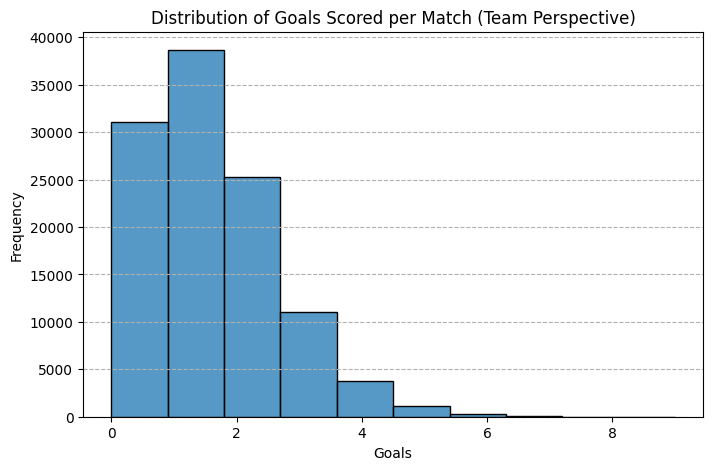


Summary statistics for Goals Scored:
count    111332.000000
mean          1.310935
std           1.180221
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           9.000000
Name: Goals, dtype: float64


In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(team_df['Goals'], bins=int(team_df['Goals'].max()) + 1, kde=False)
plt.title("Distribution of Goals Scored per Match (Team Perspective)")
plt.xlabel("Goals")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--')
plt.show()

print("\nSummary statistics for Goals Scored:")
print(team_df['Goals'].describe())


# **Observation:** The distribution is right-skewed, with most teams scoring 0, 1, or 2 goals per match. Higher goal counts are less frequent.
#
# ### 3.2 Simple Feature Correlation
#
# How do other *numerical* statistics from the *same match* correlate with goals scored?

In [12]:

numeric_cols = team_df.select_dtypes(include=np.number).columns.tolist()
# Remove the target variable and potentially identifier-like columns if they were numeric
features_for_corr = [col for col in numeric_cols if col not in ['Goals', 'IsHome']] # IsHome is boolean treated as number


correlations = team_df[features_for_corr + ['Goals']].corr()['Goals'].sort_values(ascending=False)
print("\nCorrelation of numeric features with Goals (from the same match):\n")
print(correlations.drop('Goals')) # Drop self-correlation




Correlation of numeric features with Goals (from the same match):

HTGoals              0.680674
ShotsOnTarget        0.454198
Shots                0.283202
HitWoodwork          0.070844
Offsides             0.065437
Corners              0.030046
Attendance           0.016349
HTGoalsConceded     -0.028175
Fouls               -0.033004
GoalsConceded       -0.047897
YellowCards         -0.049317
RedCards            -0.073564
BookingPoints       -0.108410
FreeKicksConceded         NaN
Name: Goals, dtype: float64


# **Observation:** Unsurprisingly, `ShotsOnTarget` and `Shots` show the highest positive correlation with `Goals` scored in the same match. `HTGoals` (Half-Time Goals) is also strongly correlated. This confirms the intuitive link between shooting and scoring. `GoalsConceded` might show a negative correlation (teams scoring more might concede less, or vice-versa, depending on game state).
#
# ### 3.3 Autocorrelation Analysis (Time Series Aspect)
#
# Does a team's goal-scoring in previous matches predict goals in the current match? We use the Autocorrelation Function (ACF).
#
# **Average ACF across all teams:**

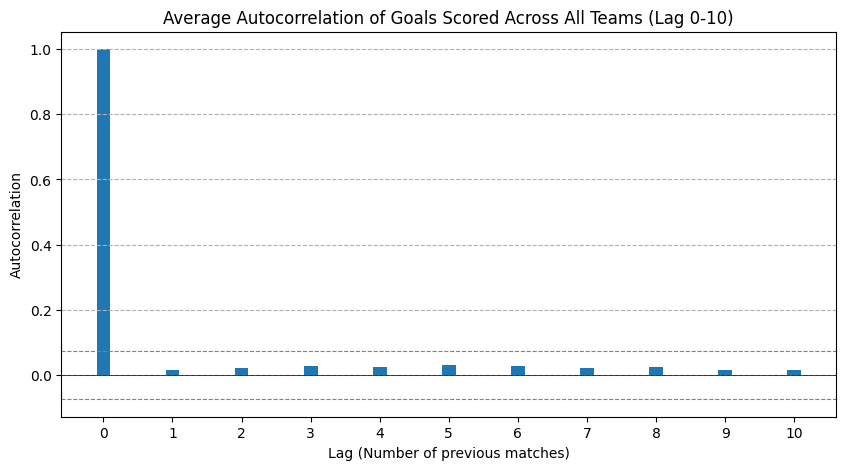

In [13]:

max_lag = 10 # How many previous matches to look back
teams = team_df['Team'].unique()
acf_matrix = []

# Loop through teams and compute ACF for 'Goals'
for team in teams:
    goals = team_df[team_df['Team'] == team]['Goals'].dropna()
    # Ensure enough data points and non-zero variance for ACF calculation
    if len(goals) > max_lag and goals.var() > 0:
        try:
            team_acf = acf(goals, nlags=max_lag, fft=False)
            acf_matrix.append(team_acf)
        except Exception as e:
            print(f"Could not compute ACF for team {team}: {e}") # Handle potential errors


# Average ACF across all teams
acf_array = np.array(acf_matrix)
avg_acf = np.mean(acf_array, axis=0)

# Plot Average ACF
plt.figure(figsize=(10, 5))
plt.bar(range(len(avg_acf)), avg_acf, width=0.2)
# Add confidence intervals (approximate for average)
conf_int = 1.96 / np.sqrt(len(team_df) / len(teams)) # Approximate avg series length
plt.axhline(y=conf_int, color='grey', linestyle='--', linewidth=0.8)
plt.axhline(y=-conf_int, color='grey', linestyle='--', linewidth=0.8)
plt.axhline(y=0, color='black', linewidth=0.5)

plt.title(f"Average Autocorrelation of Goals Scored Across All Teams (Lag 0-{max_lag})")
plt.xlabel("Lag (Number of previous matches)")
plt.ylabel("Autocorrelation")
plt.xticks(range(len(avg_acf)))
plt.grid(axis='y', linestyle='--')
plt.show()


# **Observation:** The ACF plot shows the correlation of goals scored with goals scored in previous matches (lags).
# * Lag 0 is always 1 (correlation with itself).
# * If the bars at lags > 0 extend beyond the dashed confidence lines, it suggests statistically significant autocorrelation.
# * Often, lag 1 (the immediately preceding match) shows some small positive autocorrelation, meaning teams that scored well in their last match might be slightly more likely to score well in the current one. The effect usually diminishes quickly for higher lags.
#
# **ACF for specific matchups (e.g., Team A vs Team B history):**
# This checks if a team's performance against a *specific opponent* in the past predicts performance in the current match against them.

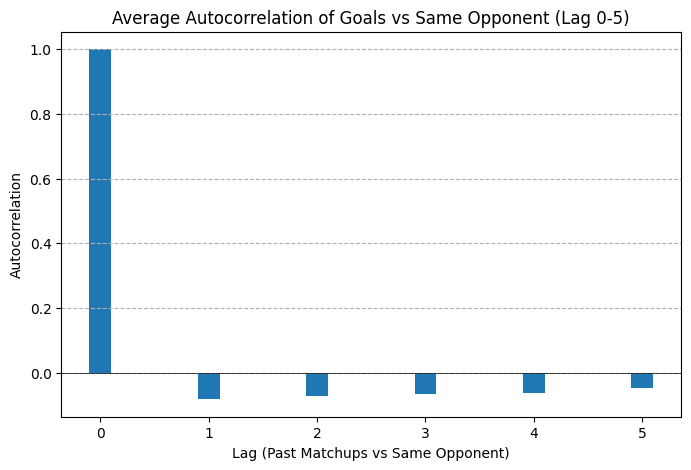


Processed 7416 team-opponent pairs for matchup ACF.


In [14]:

max_lag_matchup = 5 # Look back at the last 5 encounters
pairwise_acfs = []
processed_pairs = 0

teams_list = team_df['Team'].unique()

for team in teams_list:
    opponents_list = team_df[team_df['Team'] == team]['Opponent'].unique()
    for opp in opponents_list:
        # Get historical matchups between this specific pair
        matchups = team_df[
            (team_df['Team'] == team) &
            (team_df['Opponent'] == opp)
        ].sort_values('Date')

        goals = matchups['Goals'].dropna()

        # Check if enough historical data and variance exists
        if len(goals) > max_lag_matchup and goals.var() > 0:
            try:
                acf_vals = acf(goals, nlags=max_lag_matchup, fft=False)
                pairwise_acfs.append(acf_vals)
                processed_pairs += 1
            except Exception as e:
                # Silently ignore pairs causing errors, or log them
                # print(f"Could not compute ACF for {team} vs {opp}: {e}")
                    pass
        elif len(goals) > max_lag_matchup and goals.var() == 0:
            # Handle case where goals were always the same
            # You might append zeros or ones depending on interpretation
            # Appending zeros seems safer as it implies no predictive power from past *variation*
            pairwise_acfs.append(np.zeros(max_lag_matchup + 1))
            pairwise_acfs[-1][0] = 1.0 # Lag 0 is always 1
            processed_pairs += 1

# Average across all valid team-opponent pairs
acf_array_pairwise = np.array(pairwise_acfs)
avg_acf_pairwise = np.mean(acf_array_pairwise, axis=0)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(range(len(avg_acf_pairwise)), avg_acf_pairwise, width=0.2)
# Note: Confidence intervals are harder to estimate meaningfully here due to varying series lengths
plt.axhline(y=0, color='black', linewidth=0.5)
plt.title(f"Average Autocorrelation of Goals vs Same Opponent (Lag 0-{max_lag_matchup})")
plt.xlabel("Lag (Past Matchups vs Same Opponent)")
plt.ylabel("Autocorrelation")
plt.xticks(range(len(avg_acf_pairwise)))
plt.grid(axis='y', linestyle='--')
plt.show()
print(f"\nProcessed {processed_pairs} team-opponent pairs for matchup ACF.")


# **Observation:** Autocorrelation in specific matchups is often weak or non-significant due to the smaller number of games between the same two teams. If significant autocorrelation were found, it might suggest specific tactical patterns or psychological effects in recurring fixtures.
#
# ### 3.4 Match Context Features
#
# Does the context of the match (cards, day of the week, kickoff time, rest days) influence scoring?
#
# **Cards Analysis (Same Match):**


--- Analyzing Relationship between Cards and Goals (Same Match) ---


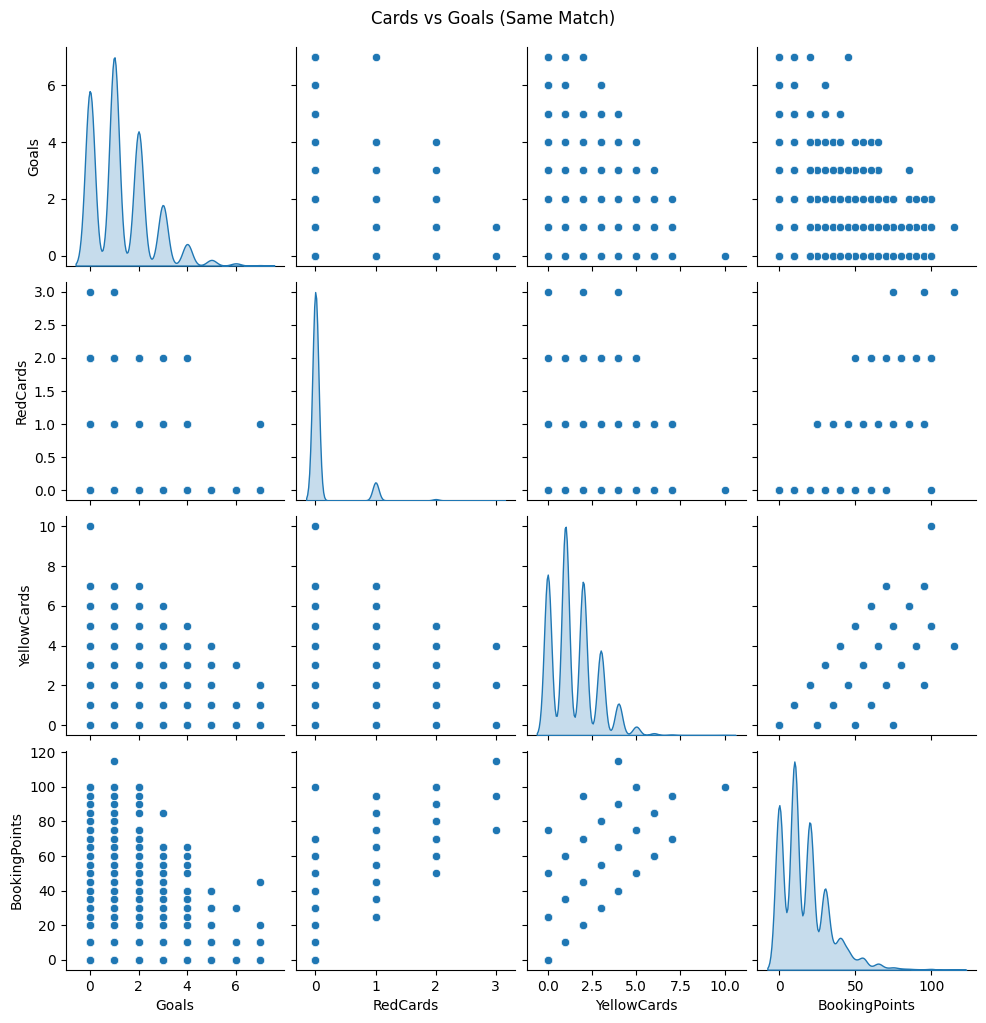

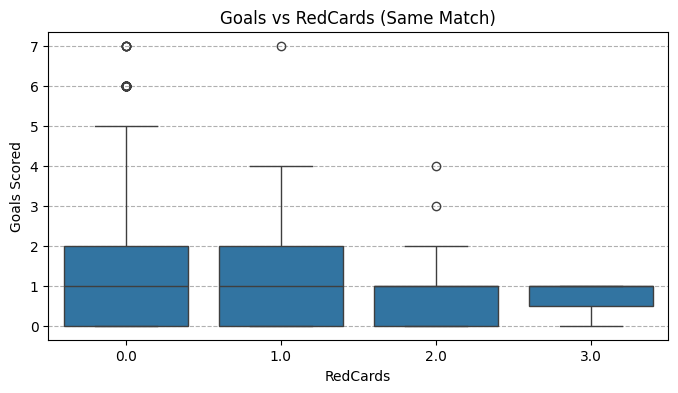

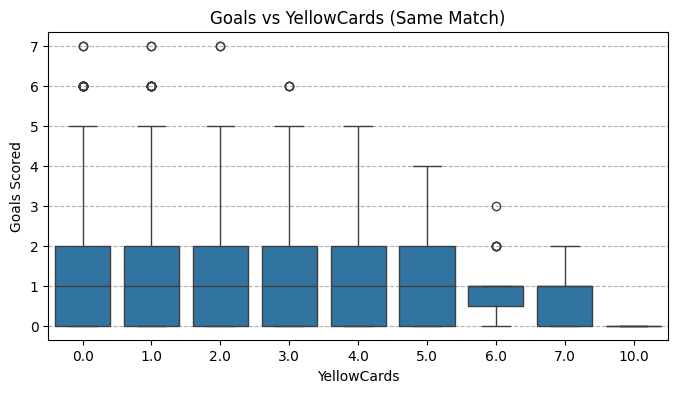

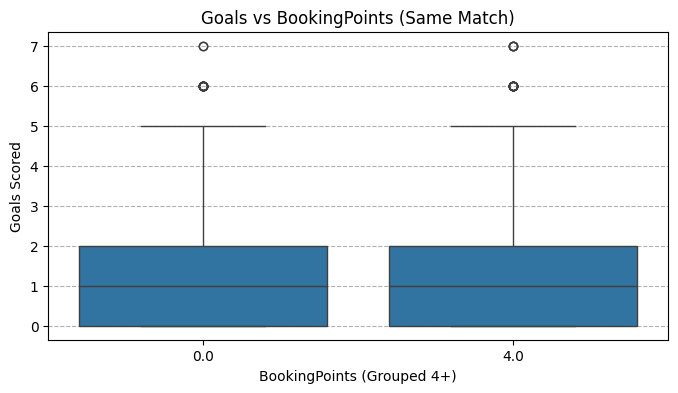

In [15]:
card_cols = ['RedCards', 'YellowCards', 'BookingPoints']

print("\n--- Analyzing Relationship between Cards and Goals (Same Match) ---")
# Check which card columns are actually available
available_card_cols = [col for col in card_cols if col in team_df.columns]

if not available_card_cols:
    print("No card columns (RedCards, YellowCards, BookingPoints) found.")
else:
    subset_cards = team_df[['Goals'] + available_card_cols].dropna()
    
    #Pairplot (optional, can be slow for large data)
    sns.pairplot(subset_cards, diag_kind='kde', kind='scatter')
    plt.suptitle("Cards vs Goals (Same Match)", y=1.02)
    plt.show()

        # Boxplots
    for card_col in available_card_cols:
        # Check if card column has variation before plotting
        if subset_cards[card_col].nunique() > 1:
            plt.figure(figsize=(8, 4))
            # Limit the number of boxes if card values are numerous (e.g., YellowCards)
            order = sorted(subset_cards[card_col].unique())
            if len(order) > 10:
                # Group higher values if needed, e.g., group 4+ yellow cards
                subset_cards[f'{card_col}_grouped'] = subset_cards[card_col].apply(lambda x: min(x, 4) if pd.notnull(x) else x) # Group 4+
                sns.boxplot(data=subset_cards, x=f'{card_col}_grouped', y='Goals')
                plt.xlabel(f'{card_col} (Grouped 4+)')
            else:
                sns.boxplot(data=subset_cards, x=card_col, y='Goals', order=order)
                plt.xlabel(card_col)

            plt.title(f"Goals vs {card_col} (Same Match)")
            plt.ylabel("Goals Scored")
            plt.grid(axis='y', linestyle='--')
            plt.show()
        else:
                print(f"Skipping plot for {card_col} as it has no variation.")


# **Observation:** Red cards often correlate with scoring *fewer* goals (or conceding more, which isn't plotted here but is related). The effect of yellow cards is usually less pronounced.
#
# **Lagged Cards Analysis:** Does getting cards in *previous* matches affect scoring in the *current* match (e.g., due to suspensions or cautious play)?


--- Analyzing Relationship between Lagged Cards and Current Goals ---


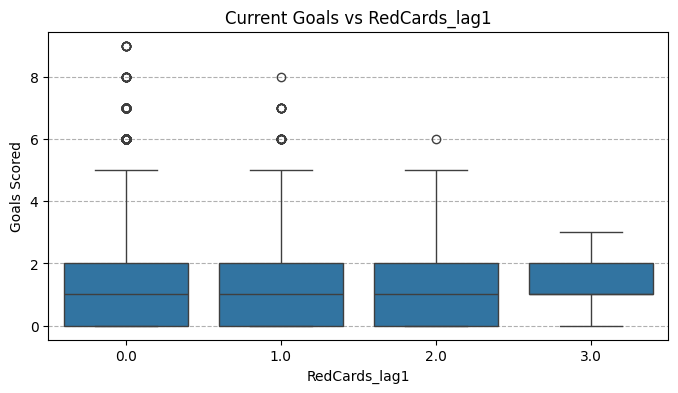

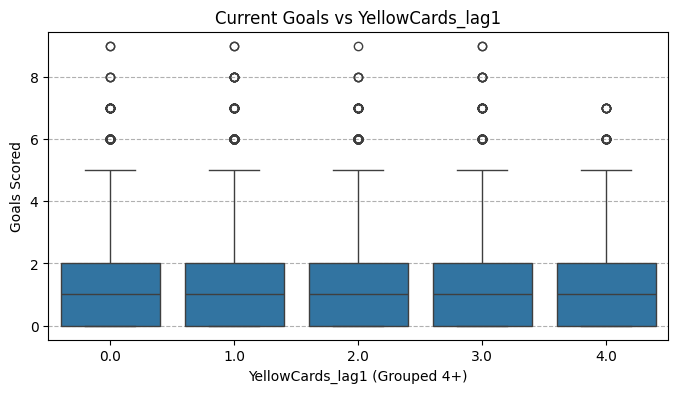

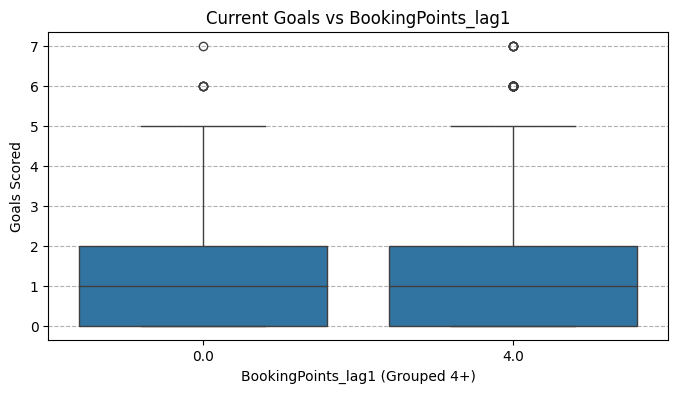

In [19]:
def add_lag_features(df, column_name, lags=[1, 2]):
    """Adds lagged features for a specified column."""
    df_out = df.copy()
    if column_name not in df_out.columns:
        print(f"Warning: Column '{column_name}' not found for lagging.")
        return df_out # Return original df if column is missing

    df_out = df_out.sort_values(['Team', 'Date', 'Time']) # Ensure correct order
    for lag in lags:
        lag_col_name = f'{column_name}_lag{lag}'
        # Use groupby().shift() to calculate lag within each team's timeline
        df_out[lag_col_name] = df_out.groupby('Team')[column_name].shift(lag)
    return df_out

# Add lagged card features (if card columns exist)
card_lags_to_add = [1] # Look at the previous match
for card_col in card_cols:
    if card_col in team_df.columns:
        team_df = add_lag_features(team_df, card_col, lags=card_lags_to_add)


print("\n--- Analyzing Relationship between Lagged Cards and Current Goals ---")
lagged_card_cols_to_plot = [f'{col}_lag{lag}' for col in card_cols for lag in card_lags_to_add if f'{col}_lag{lag}' in team_df.columns]


for lag_col in lagged_card_cols_to_plot:
    # Check for variation before plotting
    if team_df[lag_col].nunique() > 1 and not team_df[lag_col].isnull().all():
            plt.figure(figsize=(8, 4))
            subset_lag_cards = team_df[['Goals', lag_col]].dropna()

            if not subset_lag_cards.empty:
                # Limit unique values shown on x-axis if needed
                order = sorted(subset_lag_cards[lag_col].unique())
                if len(order) > 10:
                    subset_lag_cards[f'{lag_col}_grouped'] = subset_lag_cards[lag_col].apply(lambda x: min(x, 4) if pd.notnull(x) else x) # Group 4+
                    sns.boxplot(data=subset_lag_cards, x=f'{lag_col}_grouped', y='Goals')
                    plt.xlabel(f'{lag_col} (Grouped 4+)')
                else:
                    sns.boxplot(data=subset_lag_cards, x=lag_col, y='Goals', order=order)
                    plt.xlabel(lag_col)

                plt.title(f"Current Goals vs {lag_col}")
                plt.ylabel("Goals Scored")
                plt.grid(axis='y', linestyle='--')
                plt.show()
            else:
                print(f"No non-null data for plotting {lag_col} vs Goals.")



# **Observation:** Any effect of past cards on current scoring is usually weak. A red card in the previous game (`RedCards_lag1 = 1`) might slightly decrease scoring potential if a key player is suspended.
#
# **Weekend vs Weekday:**


--- Analyzing Goals Scored: Weekday vs Weekend ---


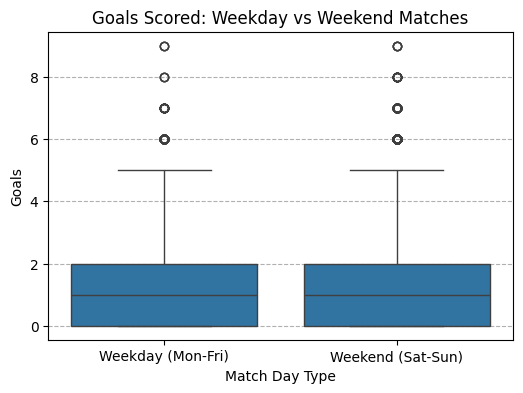


Average Goals:
IsWeekendMatch
0    1.294805
1    1.318176
Name: Goals, dtype: float64


In [20]:

print("\n--- Analyzing Goals Scored: Weekday vs Weekend ---")
team_df['DayOfWeek'] = team_df['Date'].dt.dayofweek # Monday=0, Sunday=6
team_df['IsWeekendMatch'] = team_df['DayOfWeek'].isin([5, 6]).astype(int) # Saturday=5, Sunday=6

if team_df['IsWeekendMatch'].nunique() > 1:
  plt.figure(figsize=(6, 4))
  sns.boxplot(data=team_df, x='IsWeekendMatch', y='Goals')
  plt.xticks([0, 1], ['Weekday (Mon-Fri)', 'Weekend (Sat-Sun)'])
  plt.title("Goals Scored: Weekday vs Weekend Matches")
  plt.ylabel("Goals")
  plt.xlabel("Match Day Type")
  plt.grid(axis='y', linestyle='--')
  plt.show()

  print("\nAverage Goals:")
  print(team_df.groupby('IsWeekendMatch')['Goals'].mean())
else:
  print("Not enough variation in match days (all weekend or all weekday).")


# **Observation:** Sometimes slight differences exist, possibly due to larger crowds or different preparation times on weekends, but often the effect is minimal.
#
# **Kickoff Time:**


--- Analyzing Goals Scored by Kickoff Hour ---


C:\Users\Jack\AppData\Local\Temp\ipykernel_26828\1448807415.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_df['KickoffHour'] = pd.to_datetime(team_df['Time'].astype(str), errors='coerce').dt.hour


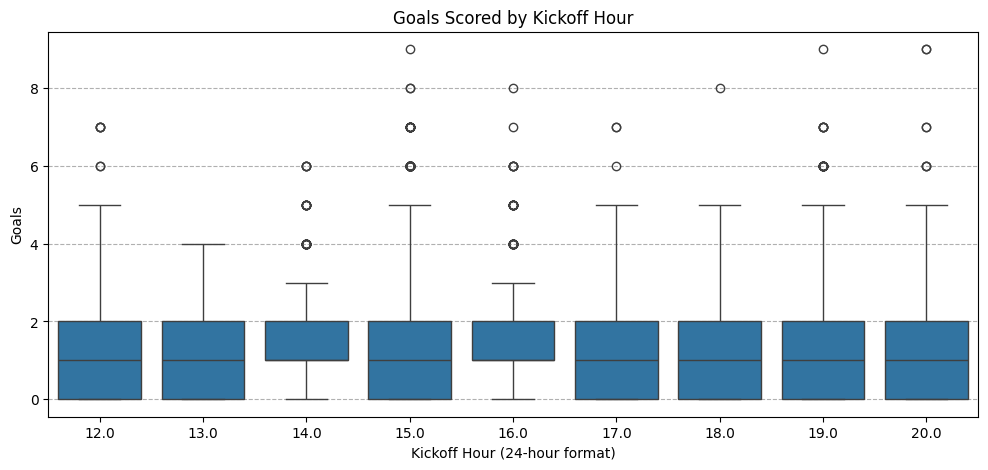

In [21]:

print("\n--- Analyzing Goals Scored by Kickoff Hour ---")
# Extract hour, handle NaT (Not a Time) values if Time conversion failed
team_df['KickoffHour'] = pd.to_datetime(team_df['Time'].astype(str), errors='coerce').dt.hour

# Plot only if KickoffHour has non-null values and variation
if team_df['KickoffHour'].notnull().any() and team_df['KickoffHour'].nunique() > 1:
   plt.figure(figsize=(12, 5))
   # Sort by hour for better visualization
   order = sorted(team_df['KickoffHour'].dropna().unique())
   sns.boxplot(data=team_df.dropna(subset=['KickoffHour']), x='KickoffHour', y='Goals', order=order)
   plt.title("Goals Scored by Kickoff Hour")
   plt.xlabel("Kickoff Hour (24-hour format)")
   plt.ylabel("Goals")
   plt.grid(axis='y', linestyle='--')
   plt.show()
else:
   print("KickoffHour data is missing, invalid, or lacks variation for plotting.")


# **Observation:** There might be patterns related to traditional afternoon kickoffs versus evening games, potentially linked to player routines or atmospheric conditions.
#
# **Rest Days / Fatigue:** How does the number of days since the last match affect scoring?

In [ ]:
if 'Goals' in team_df.columns and 'Date' in team_df.columns:
    print("\n--- Analyzing Impact of Rest Days on Goals Scored ---")
    team_df = team_df.sort_values(['Team', 'Date', 'Time'])
    # Calculate days since the *previous* match for the *same team*
    team_df['DaysSinceLastMatch'] = team_df.groupby('Team')['Date'].diff().dt.days

    # Initial look (scatterplot) - limit range for clarity
    plt.figure(figsize=(10, 5))
    # Filter out very long gaps (e.g., off-season) and first match for each team (NaN)
    filtered_rest_df = team_df[(team_df['DaysSinceLastMatch'] > 0) & (team_df['DaysSinceLastMatch'] <= 21)]
    if not filtered_rest_df.empty:
        sns.scatterplot(data=filtered_rest_df, x='DaysSinceLastMatch', y='Goals', alpha=0.2)
        # Add a regression line to see the trend
        sns.regplot(data=filtered_rest_df, x='DaysSinceLastMatch', y='Goals', scatter=False, color='red', line_kws={'linewidth': 2})
        plt.title("Goals Scored vs Days Since Last Match (1-21 Days)")
        plt.xlabel("Days Since Last Match")
        plt.ylabel("Goals Scored")
        plt.grid(axis='y', linestyle='--')
        plt.xticks(range(1, 22))
        plt.show()
    else:
        print("Not enough data with 1-21 days rest for scatter plot.")


    # Boxplot with buckets for better summary view
    # Handle NaN (first match) and group longer rests
    def bucket_days(x):
        if pd.isnull(x):
            return 'First Match'
        elif x <= 4:
            return '1-4 Days'
        elif x <= 7:
            return '5-7 Days'
        elif x <= 14:
            return '8-14 Days'
        else:
            return '15+ Days'

    team_df['RestBucket'] = team_df['DaysSinceLastMatch'].apply(bucket_days)

    plt.figure(figsize=(10, 5))
    order = ['First Match', '1-4 Days', '5-7 Days', '8-14 Days', '15+ Days']
    # Filter out potential future buckets if data doesn't contain them
    order = [b for b in order if b in team_df['RestBucket'].unique()]
    if team_df['RestBucket'].nunique() > 1:
        sns.boxplot(data=team_df, x='RestBucket', y='Goals', order=order)
        plt.title("Goals Scored by Rest Days Category")
        plt.xlabel("Days Since Last Match")
        plt.ylabel("Goals Scored")
        plt.grid(axis='y', linestyle='--')
        plt.show()

        print("\nAverage Goals by Rest Category:")
        print(team_df.groupby('RestBucket')['Goals'].agg(['mean', 'count']))
    else:
        print("Not enough variation in rest days for bucketed boxplot.")

else:
    print("\nGoals or Date column not available for Rest Days analysis.")

**Observation:** Very short rest periods (e.g., 1-3 days) might slightly decrease scoring due to fatigue. Extremely long rests (off-season) can also lead to rustiness. Often, a standard rest of ~4-7 days shows peak performance. `DaysSinceLastMatch` seems like a potentially useful autoregressive feature.
#
### **Match Congestion:** How many matches has the team played recently?

In [26]:
df.columns

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'HG', 'FTAG',
       'AG', 'FTR', 'Res', 'HTHG', 'HTAG', 'HTR', 'Attendance', 'Referee',
       'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC', 'HF', 'AF', 'HFKC',
       'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP'],
      dtype='object')

In [24]:
def add_matches_in_window(df, days=28):
    """Calculates matches played by the team in the preceding 'days'."""
    df_out = df.sort_values(['Team', 'Date', 'Time']).copy()
    df_out[f'MatchesLast{days}Days'] = 0 # Initialize column

    # Use rolling apply on dates for efficiency if possible
    # This requires setting the date as index temporarily
    df_out = df_out.set_index('Date', drop=False)
    # The lambda function counts rows within the date window for each team
    # Note: 'closed='left'' excludes the current day's match
    # 'min_periods=0' handles the start of the series correctly
    rolling_count = df_out.groupby('Team').rolling(window=f'{days}D', closed='left')['Team'].count()
    # The result has a multi-index (Team, Date), we need to align it back
    # Dropping the 'Team' level from the index and assigning
    df_out[f'MatchesLast{days}Days'] = rolling_count.reset_index(level=0, drop=True)
    # Fill NaN values resulting from the rolling window (especially at the start) with 0
    df_out[f'MatchesLast{days}Days'] = df_out[f'MatchesLast{days}Days'].fillna(0).astype(int)

    return df_out.reset_index() # Reset Date index back to column


if 'Goals' in team_df.columns and 'Date' in team_df.columns:
    print("\n--- Analyzing Impact of Match Congestion (Matches in Last 28 Days) ---")
    team_df = add_matches_in_window(team_df, days=28)

    if 'MatchesLast28Days' in team_df.columns and team_df['MatchesLast28Days'].nunique() > 1:
      plt.figure(figsize=(12, 5))
      # Ensure x-axis is ordered correctly
      order = sorted(team_df['MatchesLast28Days'].unique())
      sns.boxplot(data=team_df, x='MatchesLast28Days', y='Goals', order=order)
      plt.title("Goals Scored vs Number of Matches Played in Last 28 Days")
      plt.xlabel("Matches Played in Prior 28 Days")
      plt.ylabel("Goals Scored")
      plt.grid(axis='y', linestyle='--')
      plt.show()

      print("\nAverage Goals by Match Congestion:")
      print(team_df.groupby('MatchesLast28Days')['Goals'].agg(['mean', 'count']))
    else:
      print("Not enough data or variation to analyze match congestion.")

else:
    print("\nGoals or Date column not available for Match Congestion analysis.")


--- Analyzing Impact of Match Congestion (Matches in Last 28 Days) ---


KeyError: 'Column not found: Team'

# **Observation:** Playing a high number of matches in a short period (e.g., 6+ matches in 28 days) could indicate fixture congestion and potentially lead to lower scoring due to fatigue or squad rotation. This is another useful autoregressive feature candidate.
#
# ### 3.5 Performance Metrics (Autoregressive Potential)
#
# Let's calculate metrics based on past performance.
#
# **Shooting Efficiency:**

In [ ]:
if 'Goals' in team_df.columns and 'Shots' in team_df.columns and 'ShotsOnTarget' in team_df.columns:
    print("\n--- Calculating Performance Metrics ---")
    # Shot Conversion Rate (Goals / Shots) for the current match
    # Handle division by zero if Shots = 0
    team_df['ShotConversionRate'] = np.where(
        team_df['Shots'] > 0,
        team_df['Goals'] / team_df['Shots'],
        0 # Assign 0% conversion if no shots were taken
    )
    # Handle potential NaN/inf if Goals or Shots were NaN initially
    team_df['ShotConversionRate'].fillna(0, inplace=True)


    # Shot Accuracy (Shots on Target / Shots) for the current match
    team_df['ShotAccuracy'] = np.where(
        team_df['Shots'] > 0,
        team_df['ShotsOnTarget'] / team_df['Shots'],
        0 # Assign 0% accuracy if no shots were taken
    )
    team_df['ShotAccuracy'].fillna(0, inplace=True)

    print("Calculated 'ShotConversionRate' and 'ShotAccuracy' for the current match.")

    # Rolling Average of Past Performance (Autoregressive Feature)
    # Calculate rolling average of conversion rate *excluding* the current match
    # Requires sorting by team and date (already done)
    rolling_window = 5 # Use performance from last 5 matches

    # Use shift(1) to exclude the current match's rate from the rolling calculation
    # Group by team, take the conversion rate, shift, then apply rolling mean
    team_df[f'ShotConversionRolling{rolling_window}'] = (
        team_df.groupby('Team')['ShotConversionRate']
        .shift(1) # Exclude current match
        .rolling(window=rolling_window, min_periods=1) # Use min_periods=1 to get value even if less than 5 past games
        .mean()
        .reset_index(level=0, drop=True) # Reset the group index to align back
    )

    team_df[f'ShotAccuracyRolling{rolling_window}'] = (
        team_df.groupby('Team')['ShotAccuracy']
        .shift(1)
        .rolling(window=rolling_window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

    # Fill initial NaNs in rolling features (first few games for each team) with 0 or a global mean if preferred
    team_df[f'ShotConversionRolling{rolling_window}'].fillna(0, inplace=True)
    team_df[f'ShotAccuracyRolling{rolling_window}'].fillna(0, inplace=True)


    print(f"Calculated Rolling {rolling_window}-match averages (excluding current match).")

    # Simple xG Proxy using rolling conversion rate
    # xG_proxy = Shots_in_this_match * Average_conversion_rate_from_past_matches
    team_df['xG_proxy_simple'] = team_df['Shots'] * team_df[f'ShotConversionRolling{rolling_window}']

    print("Calculated simple xG proxy: xG_proxy_simple = Shots * ShotConversionRolling5")

    # Visualize correlation between proxy and actual goals
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=team_df, x='xG_proxy_simple', y='Goals', alpha=0.3)
    # Add a y=x line for reference (perfect prediction)
    max_val = max(team_df['xG_proxy_simple'].max(), team_df['Goals'].max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y=x')
    plt.title("Simple xG Proxy vs Actual Goals Scored")
    plt.xlabel("xG Proxy (Shots * Rolling 5-Match Conversion Rate)")
    plt.ylabel("Actual Goals Scored")
    plt.grid(axis='both', linestyle='--')
    plt.legend()
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()

    print("\nCorrelation between simple xG proxy and actual Goals:")
    print(team_df[['xG_proxy_simple', 'Goals']].corr())

else:
    print("\nGoals, Shots, or ShotsOnTarget column not available for performance metric calculation.")

# **Observation:** Rolling averages of performance metrics (like shot conversion rate or accuracy) are key autoregressive features. They capture a team's recent form in terms of efficiency. The simple xG proxy, which combines current match shots with past conversion efficiency, often shows a reasonable correlation with actual goals scored, indicating the predictive power of combining current actions with past trends.
#
# **Rolling Average Goals:** Also create rolling averages for goals scored and conceded.

In [ ]:
if 'Goals' in team_df.columns and 'GoalsConceded' in team_df.columns:
    rolling_window = 5 # Use performance from last 5 matches

    # Rolling average goals scored
    team_df[f'AvgGoalsScoredRolling{rolling_window}'] = (
        team_df.groupby('Team')['Goals']
        .shift(1)
        .rolling(window=rolling_window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    team_df[f'AvgGoalsScoredRolling{rolling_window}'].fillna(0, inplace=True)

    # Rolling average goals conceded
    team_df[f'AvgGoalsConcededRolling{rolling_window}'] = (
        team_df.groupby('Team')['GoalsConceded']
        .shift(1)
        .rolling(window=rolling_window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    team_df[f'AvgGoalsConcededRolling{rolling_window}'].fillna(0, inplace=True) # Fill initial NaNs

    print(f"\nCalculated Rolling {rolling_window}-match averages for Goals Scored and Conceded.")
    print(team_df[[f'AvgGoalsScoredRolling{rolling_window}', f'AvgGoalsConcededRolling{rolling_window}']].head())

else:
     print("\nGoals or GoalsConceded columns not available for rolling average calculation.")

# ## 4. Feature Set Definition
#
# Based on the exploration, we can define two feature sets for potential xG modeling:
#
# 1.  **Base Feature Set (Non-Autoregressive):** Uses only information available *about the current match* without considering the team's specific recent history or form (beyond maybe their opponent).
# 2.  **Autoregressive Feature Set:** Includes the base features plus features derived from the team's recent past performance and context.
#
# *Note:* For a real model, you'd also want features representing the *opponent's* strength and recent form. We'll keep it simpler here, focusing on the team's own features. You would typically create opponent features (e.g., `Opponent_AvgGoalsConcededRolling5`) by merging them onto the `team_df` based on the `Opponent` and `Date` columns.

In [ ]:
# --- Define Feature Sets ---

# Identify potential features created during EDA
all_potential_features = team_df.columns.tolist()

# BASE FEATURES: Focus on current match context, excluding direct performance history/lags
#                (Could include opponent strength metrics if calculated separately)
base_features = [
    'IsHome',             # Home advantage indicator
    'IsWeekendMatch',     # Match timing context
    # 'KickoffHour',        # Match timing context (consider binning or encoding)
    # 'Attendance',         # Potential proxy for match importance/atmosphere (handle NaNs)
    # 'Referee',            # Categorical, would need encoding (often noisy)
    # 'Div'                 # League/Division (Categorical, needs encoding)
    # Add opponent strength features here if created (e.g., Opponent_AvgGoalsConceded)
]
# Filter base_features to only include those actually present in the final DataFrame
base_features = [f for f in base_features if f in team_df.columns]


# AUTOREGRESSIVE FEATURES: Includes base features PLUS lagged/rolling features
autoregressive_features = base_features + [
    # Rolling performance metrics
    'ShotConversionRolling5',
    'ShotAccuracyRolling5',
    'AvgGoalsScoredRolling5',
    'AvgGoalsConcededRolling5',

    # Fatigue / Congestion
    'DaysSinceLastMatch',     # Needs handling for NaNs (first match) - maybe impute or use bucket
    'MatchesLast28Days',

    # Recent events (lags)
    'RedCards_lag1',          # Example lag feature (if useful)
    # 'YellowCards_lag1',
    # 'Goals_lag1',           # Could add lagged goals directly if ACF showed strong signal

    # Simple xG proxy (derived from rolling avg)
    'xG_proxy_simple',

    # You might also include rolling averages of shots, corners, etc.
    # 'AvgShotsRolling5',
    # 'AvgCornersRolling5',
]
# Filter autoregressive_features to only include those actually present in the final DataFrame
autoregressive_features = [f for f in autoregressive_features if f in team_df.columns]
# Ensure no duplicates if features were added manually above
autoregressive_features = list(dict.fromkeys(autoregressive_features))


# --- Define Target Variable ---
target = 'Goals'

# --- Display the chosen features ---
print("\n--- Feature Set Definitions ---")

print("\nTarget Variable:")
print(f"- {target}")

print(f"\nBase Feature Set (Non-Autoregressive) - {len(base_features)} features:")
# Check if target accidentally included
base_features = [f for f in base_features if f != target]
print(base_features)

print(f"\nAutoregressive Feature Set - {len(autoregressive_features)} features:")
# Check if target accidentally included
autoregressive_features = [f for f in autoregressive_features if f != target]
print(autoregressive_features)

# --- Final DataFrame Sample with potential features ---
# Select a subset of columns for final display including target and key features
cols_to_show = [target] + base_features + [f for f in autoregressive_features if f not in base_features]
cols_to_show = list(dict.fromkeys(cols_to_show)) # Remove duplicates
cols_to_show = [c for c in cols_to_show if c in team_df.columns] # Ensure all exist
print("\nSample of final DataFrame with target and selected features:")
print(team_df[cols_to_show].tail(10)) # Show last few rows as they include rolling features

# ## 5. Conclusion & Next Steps
#
# This notebook explored football match data to identify potential features for predicting goals scored by a team, with a focus on understanding the value of autoregressive (time-dependent) features.
#
# **Key Findings & Feature Engineering:**
# * Transformed data to a team-per-match format, essential for time series analysis.
# * Confirmed basic correlations (Shots, ShotsOnTarget -> Goals).
# * ACF analysis suggested limited, short-term autocorrelation in goal scoring for teams overall, but potentially stronger signals in rolling performance metrics.
# * Explored match context features like rest days (`DaysSinceLastMatch`) and match congestion (`MatchesLast28Days`), which showed potential relationships with scoring and are inherently autoregressive.
# * Calculated rolling averages for key performance indicators (Shot Conversion, Accuracy, Goals Scored/Conceded), capturing recent form.
# * Created a simple xG proxy based on current shots and recent conversion rates.
#
# **Feature Sets Defined:**
# 1.  **Base Set:** Contains features describing the current match context (`IsHome`, `IsWeekendMatch`, potentially opponent strength) without using the team's specific recent performance lags or averages.
# 2.  **Autoregressive Set:** Extends the base set by adding features that capture recent form and historical context, such as rolling performance averages, rest days, match congestion, and potentially lagged events like cards or goals.
#
# **Next Steps:**
# * **Handle Missing Values:** Thoroughly address NaNs in the selected features (e.g., using imputation for `DaysSinceLastMatch` in the first game).
# * **Encode Categorical Features:** Convert features like `Div` or `Referee` (if used) into numerical representations (e.g., one-hot encoding).
# * **Feature Scaling:** Apply scaling (e.g., StandardScaler) to numerical features, especially for models sensitive to feature ranges.
# * **Add Opponent Features:** Create and merge features representing the opponent's strength and form (e.g., `Opponent_AvgGoalsConcededRolling5`). This is crucial for a realistic model.
# * **Model Training & Evaluation:** Train predictive models (e.g., Linear Regression, Gradient Boosting) using both feature sets and compare their performance (e.g., using RMSE or MAE on predicting `Goals`) via appropriate validation (like TimeSeriesSplit) to test the hypothesis that autoregressive features improve prediction accuracy for xG components.